In [1]:
import pandas as pd
import glob
import os
import re

import re
import pandas as pd
import os
import pytz
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import matplotlib.gridspec as gridspec
import itertools
import calendar
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from IPython.display import display

in_color = 'blue'
out_color = 'green'
ratio_color = 'black'

In [3]:
# Define custom positions for boxplots: Two close, then a gap
def generate_positions(n_groups, spacing=2.2, inner_spacing=0.8):
    positions = []
    base = 1  # Start position
    for _ in range(n_groups):
        positions.append(base)  # First box in pair
        positions.append(base + inner_spacing)  # Second box in pair
        base += spacing  # Larger gap before next pair
    return positions

def set_box_outline_colors(box, colors):
    color_cycle = itertools.cycle(colors)
    for patch in box['boxes']:
        patch.set(color=next(color_cycle))  # Set box outline color
    colors = [colors[0], colors[0], colors[1], colors[1]]
    color_cycle = itertools.cycle(colors)
    for whisker in box['whiskers']:  # Set whisker colors
        whisker.set(color=next(color_cycle))
    for cap in box['caps']:  # Set cap colors
        cap.set(color=next(color_cycle))
    for median in box['medians']:  # Make median lines black for contrast
        median.set(color="red")


#### Time series plot calibrated atm

In [ ]:
## Time series plot indoor and outdoor
## plotting

dir = 'Data/Raw Clone'
target = 'graphs/time series'

subdirs = ["Dhakeshwari Home","Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"] + ["Dania Home", "Badda Home"]
# subdirs = ["Mohakhali Home"]

for home in subdirs:
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']

    combined_df = pd.merge(indoor_df, outdoor_df, on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0 and x < 2) else float('nan'))
    # combined_df = combined_df.dropna(subset = ['IO_ratio'])
    print(f"Processed {home}")

    plt.figure(figsize=(6.5, 4.5))

    # Plot the PM2.5 concentrations
    plt.plot(combined_df['time'], combined_df['pm2_5_indoor'], label="Indoor Concentration", color=in_color, linestyle='-', markersize=3, linewidth = .3)
    plt.plot(combined_df['time'], combined_df['pm2_5_outdoor'], label="Outdoor Concentration", color=out_color, linestyle='-', markersize=3, linewidth = .3)
    # Define the background shading for wet and dry seasons
    start_date = 2023
    end_date =  2025
    for year in range(start_date, end_date):
        plt.axvspan(pd.Timestamp(f'{year}-04-01'), pd.Timestamp(f'{year}-09-30'), color='lightblue', alpha=0.5, label='Wet Season' if year == start_date else '')  # Wet season
        plt.axvspan(pd.Timestamp(f'{year}-10-01'), pd.Timestamp(f'{year+1}-03-31'), color='khaki', alpha=0.5, label='Dry Season' if year == start_date else '')  # Dry season

    # Labels and title
    plt.xlabel('Time')
    plt.ylabel(r'$PM_{2.5}$ concentration Hourly Average' + '\n' + r'($\mu g/m^{3}$)')
    plt.title(f'Time series plot of {home.split(' ')[0]}')
    # plt.text(2, 3, "Hello")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate time labels for better visibility
    plt.xlim(pd.to_datetime('2023-07-01'), pd.to_datetime('2024-12-31'))
    plt.ylim((0, 500))
    plt.tight_layout()
    plt.savefig(os.path.join(target, f'{home}.png'), dpi = 300)
    plt.show()
    



: 

####  Monthly average of calibrated data

processing Dhakeshwari Home
processing Mohammadpur Home


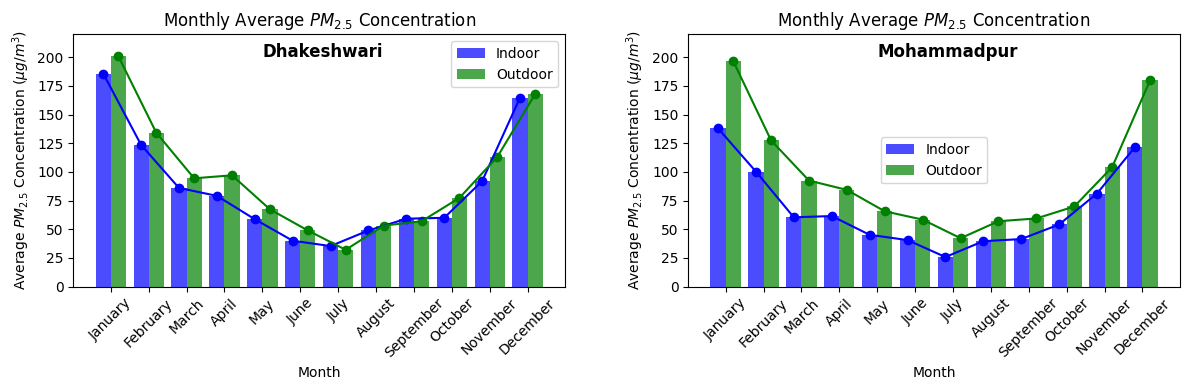

processing Mohakhali Home
processing Nakhalpara Home


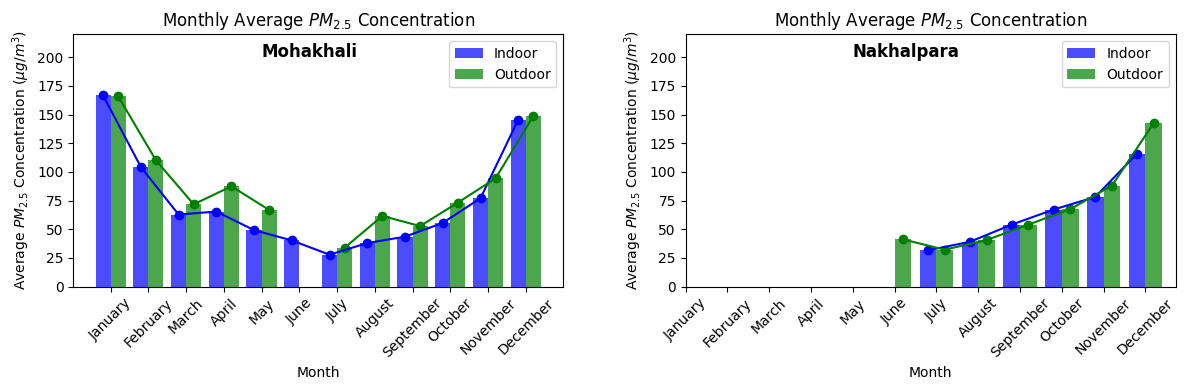

processing Badda Home
processing Banasree Home


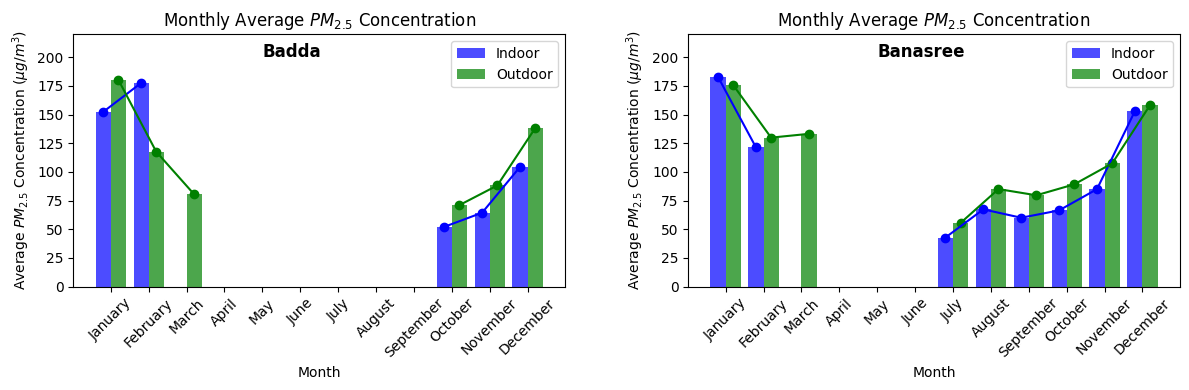

processing Khilgawn Home
processing Dania Home


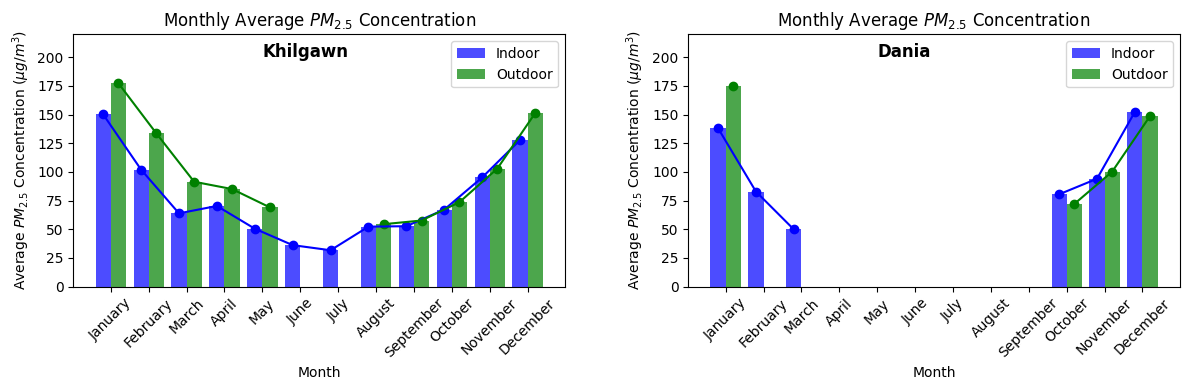

In [37]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/monthly average'

# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dhakeshwari Home", "Mohammadpur Home", "Mohakhali Home", "Nakhalpara Home", "Badda Home", "Banasree Home", "Khilgawn Home", "Dania Home"]
# subdirs = ['Dhakeshwari Home']

i = 1
for home in subdirs:
    print(f"processing {home}")
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]

    # Extract month numbers for grouping
    indoor_df['Month'] = indoor_df['time'].dt.month
    outdoor_df['Month'] = outdoor_df['time'].dt.month

    all_months = [i for i in range(1, 13)]

    # Calculate monthly average PM2.5 concentrations
    indoor_monthly_avg = indoor_df.groupby('Month')['pm2_5_atm_calibrated'].mean().reindex(all_months, fill_value=float('nan'))
    outdoor_monthly_avg = outdoor_df.groupby('Month')['pm2_5_atm_calibrated'].mean().reindex(all_months, fill_value=float('nan'))

    if home in ["Dania Home", "Badda Home"]:
        indoor_monthly_avg[indoor_monthly_avg.index.isin([4, 5, 6, 7, 8, 9])] = float('nan')
        outdoor_monthly_avg[outdoor_monthly_avg.index.isin([4, 5, 6, 7, 8, 9])] = float('nan')
    # Get month names instead of numbers
    month_labels = [calendar.month_name[m] for m in indoor_monthly_avg.index]  # Convert 1-12 to month names

    # Define X-axis positions
    x = np.arange(len(month_labels))  

    # Plot bar chart
    width = 0.4

    if i== 1:
        plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, i)
    plt.bar(x - width/2, indoor_monthly_avg, width=width, label="Indoor", alpha=0.7, color='blue')
    plt.bar(x + width/2, outdoor_monthly_avg, width=width, label="Outdoor", alpha=0.7, color='green')

    plt.plot(x - width/2, indoor_monthly_avg,color='blue')
    plt.plot(x + width/2, outdoor_monthly_avg, color = 'green')

    plt.scatter(x - width/2, indoor_monthly_avg,color='blue')
    plt.scatter(x + width/2, outdoor_monthly_avg, color = 'green')

    # Labels and title
    plt.xlabel("Month")
    plt.ylabel(r"Average $PM_{2.5}$ Concentration ($\mu g/m^3$)")
    plt.title(r"Monthly Average $PM_{2.5}$ Concentration")

    # Set month names as x-axis labels
    plt.xticks(x, month_labels, rotation=45)  # Set proper month labels with rotation
    plt.ylim((0, 220))
    plt.text(4, 200, home.split(' ')[0], fontsize = 12, fontweight = "bold")
    plt.legend()
    # plt.grid(axis='y')
    # Show the plot
    if i == 1:
        i = 2
    else:
        
        i = 1
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.25, hspace=0.6)
        plt.savefig(f'graphs/monthly average/merged/{home}.png', dpi = 300)
        plt.show()
        

  0%|          | 0/9 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Ajimpur Home
Processing Badda Home
Processing Banasree Home
Processing Dania Home
Processing Khilgawn Home
Processing Nakhalpara Home


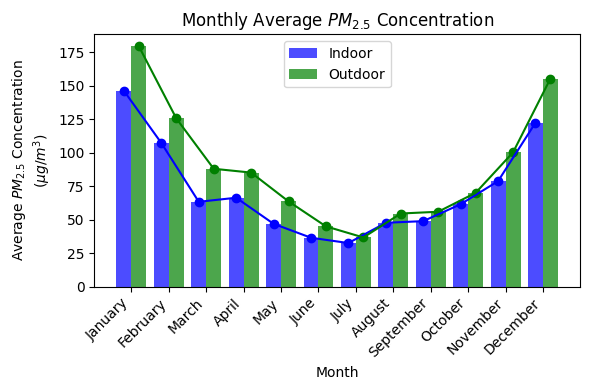

In [63]:
## Monthly average box plot

Indoor_dfs = []
Outdoor_dfs = []

dir = 'Data/Raw Clone'
subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    for file in files:
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        if type == "Indoor":
            Indoor_dfs.append(df)

        elif type == "Outdoor":
            Outdoor_dfs.append(df)

# Concatenate DataFrames
indoor_df = pd.concat(Indoor_dfs)
outdoor_df = pd.concat(Outdoor_dfs)

# Ensure 'time' is in datetime format
indoor_df['time'] = pd.to_datetime(indoor_df['time'])
outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])

# Extract month numbers for grouping
indoor_df['Month'] = indoor_df['time'].dt.month
outdoor_df['Month'] = outdoor_df['time'].dt.month

# Calculate monthly average PM2.5 concentrations
indoor_monthly_avg = indoor_df.groupby('Month')['pm2_5_atm_calibrated'].mean()
outdoor_monthly_avg = outdoor_df.groupby('Month')['pm2_5_atm_calibrated'].mean()

# Get month names instead of numbers
month_labels = [calendar.month_name[m] for m in indoor_monthly_avg.index]  # Convert 1-12 to month names

# Define X-axis positions
x = np.arange(len(month_labels))  

# Plot bar chart
width = 0.4

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, indoor_monthly_avg, width=width, label="Indoor", alpha=0.7, color='blue')
plt.bar(x + width/2, outdoor_monthly_avg, width=width, label="Outdoor", alpha=0.7, color='green')

plt.plot(x - width/2, indoor_monthly_avg,color='blue')
plt.plot(x + width/2, outdoor_monthly_avg, color = 'green')

plt.scatter(x - width/2, indoor_monthly_avg,color='blue')
plt.scatter(x + width/2, outdoor_monthly_avg, color = 'green')

# Labels and title
plt.xlabel("Month")
plt.ylabel(r"Average $PM_{2.5}$ Concentration" + "\n" +  r"($\mu g/m^3$)")
plt.title(r"Monthly Average $PM_{2.5}$ Concentration")

# Set month names as x-axis labels
plt.xticks(x, month_labels, rotation=45, ha = 'right')  # Set proper month labels with rotation

plt.legend()
# plt.grid(axis='y')
plt.tight_layout()
plt.savefig('graphs/monthly average/full data.png', dpi = 300)
# Show the plot
plt.show()

#### Boxplots

  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1769161428.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  dry_plot = ax[0, 0].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=dry_positions[0:-4] + [x+.5 for x in dry_positions[-4:]], showmeans = True)


  0%|          | 0/6 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1769161428.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  wet_plot = ax[0, 1].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=wet_positions, showmeans = True)


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1769161428.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[1, 0].boxplot(dryboxPlotArray, labels=[x.split(' ')[0] for x in dryboxPlotLabel], showfliers=False, positions = [1, 2, 3, 4, 5, 6, 7.5, 8.5], showmeans = True)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1769161428.py:200: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[1, 1].boxplot(wetboxPlotArray, labels=[x.split(' ')[0] for x in wetboxPlotLabel], showfliers=False, showmeans = True)


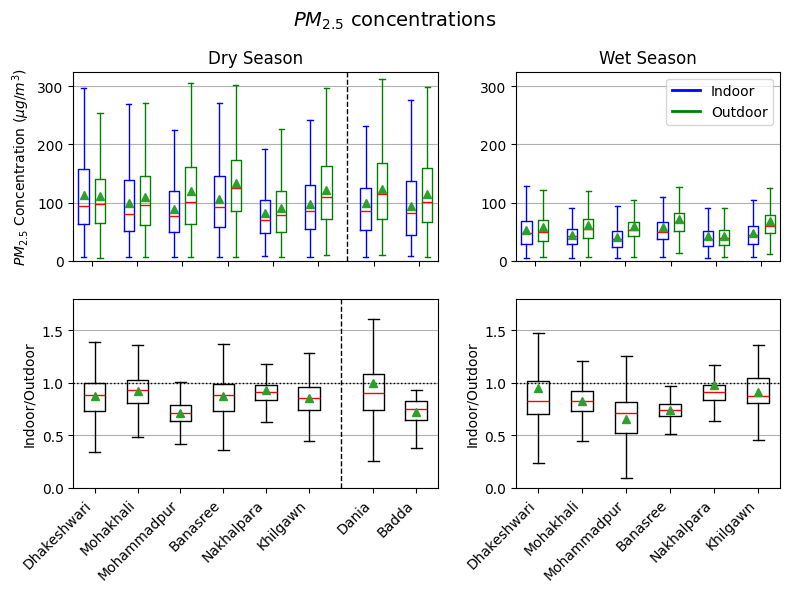

In [45]:
boxPlotArray = []
boxPlotLabel = []

# Define alternating colors
colors = ["blue", "green"]  # You can customize these colors
color_cycle = itertools.cycle(colors)  # Create an alternating cycle

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

for subdir in tqdm(subdirs):

    print(f'Processing {subdir}')
    files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        # wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        dry = np.concatenate(dry)
        # wet = np.concatenate(wet)

        boxPlotArray.append(dry)
        # boxPlotArray.append(wet)

        boxPlotLabel.append(f'{type}_{subdir}')
        # boxPlotLabel.append(f'Wet_{type}_{subdir}')
        

# Create a boxplot for the four categories
fig, ax = plt.subplots(2, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [58, 42]}) 

# Plot Dry Season
dry_positions = generate_positions(len(boxPlotArray) // 2)
dry_plot = ax[0, 0].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=dry_positions[0:-4] + [x+.5 for x in dry_positions[-4:]], showmeans = True)
set_box_outline_colors(dry_plot, colors)
ax[0, 0].axvline(x = 13.8, color='black', linestyle='--', linewidth = 1)
ax[0, 0].set_title("Dry Season", fontsize = 12)
ax[0, 0].set_ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].grid(True, axis = 'y')
ax[0, 0].set_ylim((0, 325))

positions = [1.4+x*2.2 for x in range(8)]
positions = positions[0:-2] + [x+.5 for x in positions[-2:]]
labels = [x.split(' ')[0].split('_')[1] for x in boxPlotLabel[0::2]]

# Apply to your subplot
ax[0, 0].set_xticks(positions)        # Fix tick positions
ax[0, 0].set_xticklabels([], rotation = 45)      # Set custom labels




########################################
boxPlotArray = []
boxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"]
for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        # dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        # dry = np.concatenate(dry)
        wet = np.concatenate(wet)

        # boxPlotArray.append(dry)
        boxPlotArray.append(wet)

        # boxPlotLabel.append(f'Dry_{type}_{subdir}')
        boxPlotLabel.append(f'{type}_{subdir}')


# Plot Wet Season
wet_positions = generate_positions(len(boxPlotArray) // 2)
wet_plot = ax[0, 1].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=wet_positions, showmeans = True)
set_box_outline_colors(wet_plot, colors)
ax[0,1].set_title("Wet Season", fontsize = 12)
# ax[1].set_ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
ax[0,1].tick_params(axis='x', rotation=90)
ax[0,1].grid(True, axis = 'y')
ax[0,1].set_ylim((0, 325))


positions = [1.4+x*2.2 for x in range(6)]
labels = [x.split(' ')[0].split('_')[1] for x in boxPlotLabel[0::2]]

# Apply to your subplot
ax[0,1].set_xticks(positions)        # Fix tick positions
ax[0,1].set_xticklabels([], rotation = 45)      # Set custom labels

Indoor = mlines.Line2D([], [], color="blue", linewidth=2, label="Indoor")
Outdoor = mlines.Line2D([], [], color="green", linewidth=2, label="Outdoor")


ax[0,1].legend(handles=[Indoor, Outdoor],
                     loc="upper right", ncols = 1)

##############################################
########################
dryboxPlotArray = []
dryboxPlotLabel = []

wetboxPlotArray = []
wetboxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

for subdir in tqdm(subdirs):
    # ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    print(f'Processing {subdir}')
    indoor_df =  pd.read_csv(os.path.join(dir, subdir, 'Hourly_average_merged_calibrated_Indoor.csv'), parse_dates=['time'])
    indoor_df.columns = ['in_' + col if col != 'time' else col for col in indoor_df.columns]
    outdoor_df = pd.read_csv(os.path.join(dir, subdir, 'Hourly_average_merged_calibrated_Outdoor.csv'), parse_dates=['time'])
    outdoor_df.columns = ['out_' + col if col != 'time' else col for col in outdoor_df.columns]

    merged_df = pd.merge(indoor_df, outdoor_df, on='time', how='inner')
    merged_df = merged_df.dropna(subset=['out_pm2_5_atm_calibrated', 'in_pm2_5_atm_calibrated'])
    merged_df['io_ratio'] = merged_df['in_pm2_5_atm_calibrated'] / merged_df['out_pm2_5_atm_calibrated']

    # merged_df = merged_df[merged_df['io_ratio'] < 5]
    dry_season = merged_df[merged_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    wet_season = merged_df[merged_df['time'].dt.month.isin([4,5, 6, 7, 8, 9])]

    dryboxPlotArray.append(dry_season['io_ratio'].to_numpy())
    dryboxPlotLabel.append(f'{subdir}')

    wetboxPlotArray.append(wet_season['io_ratio'].to_numpy())
    wetboxPlotLabel.append(f'{subdir}')

wetboxPlotArray = wetboxPlotArray[0:-2]
wetboxPlotLabel = wetboxPlotLabel[0:-2]   


# Create a boxplot for the four categories

box = ax[1, 0].boxplot(dryboxPlotArray, labels=[x.split(' ')[0] for x in dryboxPlotLabel], showfliers=False, positions = [1, 2, 3, 4, 5, 6, 7.5, 8.5], showmeans = True)
ax[1, 0].axvline(x = 6.75, color='black', linestyle='--', linewidth = 1)
ax[1, 0].axhline(y=1, color='black', linestyle='dotted', linewidth=1)  # Horizontal dashed line at y=1
ax[1, 0].set_ylabel(r'Indoor/Outdoor')  # Corrected method for ylabel
ax[1, 0].tick_params(axis='x', rotation=45)  # Corrected x-axis rotation
for label in ax[1, 0].get_xticklabels():
    label.set_ha('right')
ax[1, 0].grid(axis='y')  # Grid only for y-direction
ax[1, 0].set_ylim((0, 1.8))  # Corrected method for setting y-axis limits

for median in box['medians']:  # Make median lines black for contrast
        median.set(color="red")

# Create a boxplot for the four categories

ax[1, 1].axhline(y=1, color='black', linestyle='dotted', linewidth=1)  # Horizontal dashed line at y=1
box = ax[1, 1].boxplot(wetboxPlotArray, labels=[x.split(' ')[0] for x in wetboxPlotLabel], showfliers=False, showmeans = True)
ax[1, 1].set_ylabel(r'Indoor/Outdoor')  # Corrected method for ylabel
ax[1, 1].tick_params(axis='x', rotation=45)  # Corrected method for rotating x-axis labels
for label in ax[1, 1].get_xticklabels():
    label.set_ha('right')
ax[1, 1].grid(axis='y')  # Grid only in the y-direction
ax[1, 1].set_ylim((0, 1.8))  # Corrected method for setting y-axis limits

for median in box['medians']:  # Make median lines black for contrast
        median.set(color="red")


# Add a main title
fig.suptitle(r"$PM_{2.5}$ concentrations", fontsize = 14)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2)
plt.savefig('graphs/box plots/concentration dry wet & ratio.png', dpi = 300)
plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_19204\930428076.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ind_plot = plt.boxplot(inboxPlotArray, labels=inboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_19204\930428076.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  outd_plot = plt.boxplot(outboxPlotArray, labels=outboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)


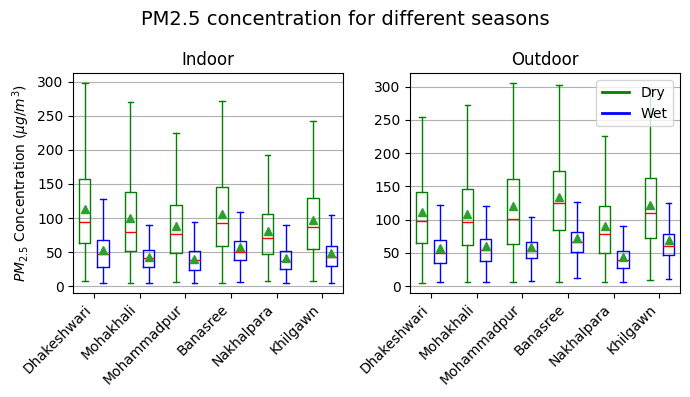

In [5]:
inboxPlotArray = []
inboxPlotLabel = []

outboxPlotArray = []
outboxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"]
for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        dry = np.concatenate(dry)
        wet = np.concatenate(wet)

        if type == "Indoor":
            inboxPlotArray.append(dry)
            inboxPlotArray.append(wet)

            inboxPlotLabel.append(f'Dry_{subdir}')
            inboxPlotLabel.append(f'Wet_{subdir}')

        elif type == "Outdoor":
            outboxPlotArray.append(dry)
            outboxPlotArray.append(wet)

            outboxPlotLabel.append(f'Dry_{subdir}')
            outboxPlotLabel.append(f'Wet_{subdir}')
        
colors = ['green', 'blue']

# Create a boxplot for the four categories
plt.figure(figsize=(7, 4))
plt.subplots_adjust( wspace=0.3)  
plt.subplot(1, 2, 1)
ind_plot = plt.boxplot(inboxPlotArray, labels=inboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
plt.xticks([1.4, 3.4, 5.4, 7.4, 9.4, 11.4], labels=[x.split(' ')[0].split('_')[1] for x in inboxPlotLabel[0::2]], rotation = 45, ha = 'right')
set_box_outline_colors(ind_plot, colors)
plt.title("Indoor", fontsize = 12)
plt.ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
plt.grid(True, axis='y')

dry = mlines.Line2D([], [], color="blue", linewidth=2, label="Dry")
wet = mlines.Line2D([], [], color="green", linewidth=2, label="Wet")


# legend2 = plt.legend(handles=[dry, wet],
#                       ncols = 1)

# Create a boxplot for the four categories
plt.subplot(1, 2, 2)
outd_plot = plt.boxplot(outboxPlotArray, labels=outboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
set_box_outline_colors(outd_plot, colors)
plt.title("Outdoor", fontsize = 12)
plt.xticks([1.4, 3.4, 5.4, 7.4, 9.4, 11.4], labels=[x.split(' ')[0].split('_')[1] for x in outboxPlotLabel[0::2]], rotation = 45, ha = 'right')

plt.grid(True, axis='y')
plt.suptitle('PM2.5 concentration for different seasons', fontsize = 14)

dry = mlines.Line2D([], [], color="green", linewidth=2, label="Dry")
wet = mlines.Line2D([], [], color="blue", linewidth=2, label="Wet")


legend2 = plt.legend(handles=[dry, wet],
                      ncols = 1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('graphs/box plots/conc indoor outdoor.png', dpi = 300)
plt.show()



#### Diurnals

processing Dhakeshwari Home


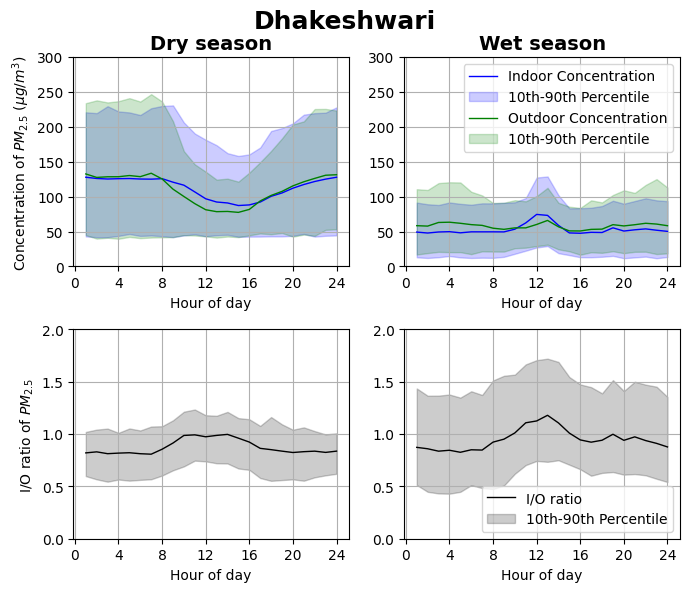

processing Mohakhali Home


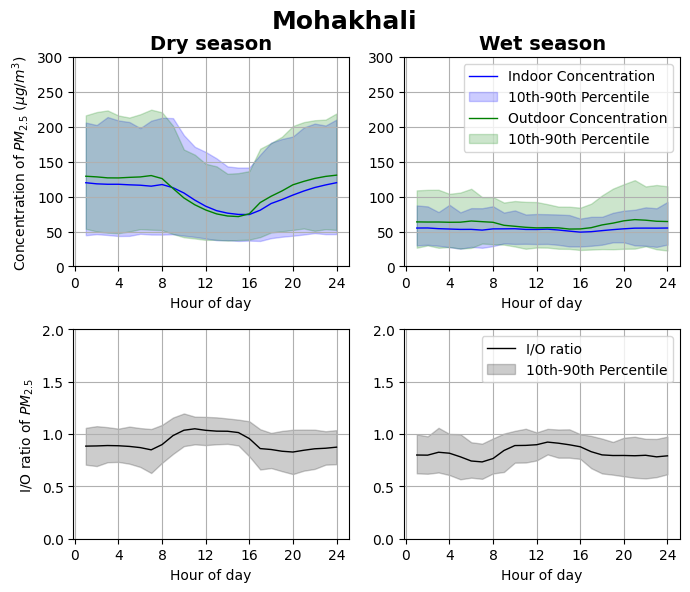

processing Mohammadpur Home


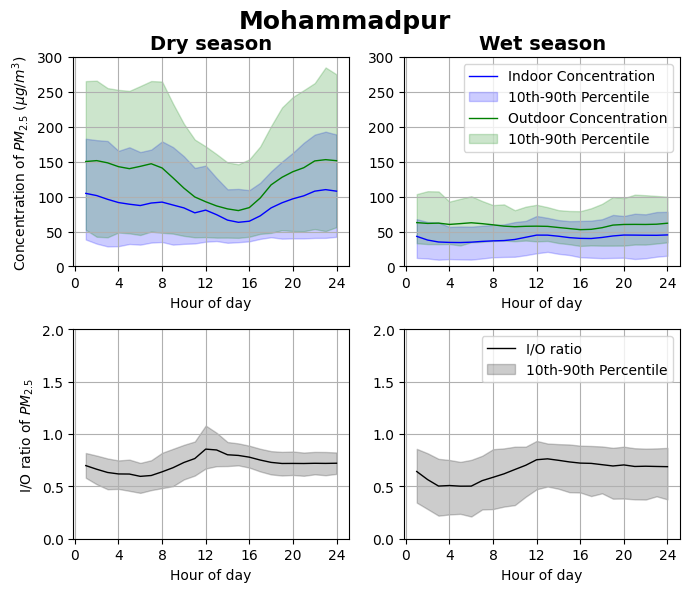

processing Banasree Home


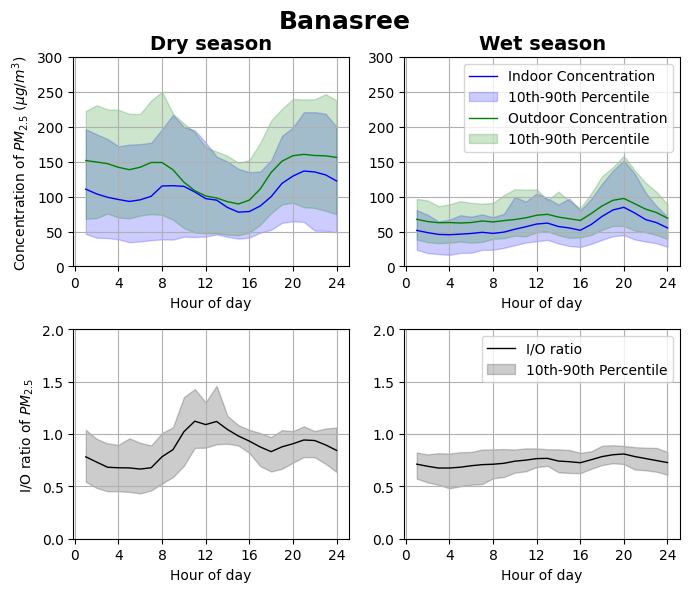

processing Nakhalpara Home


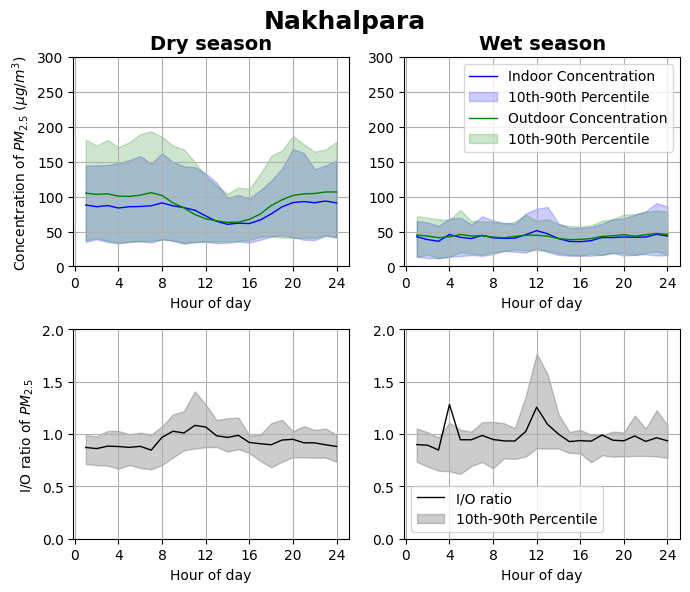

processing Khilgawn Home


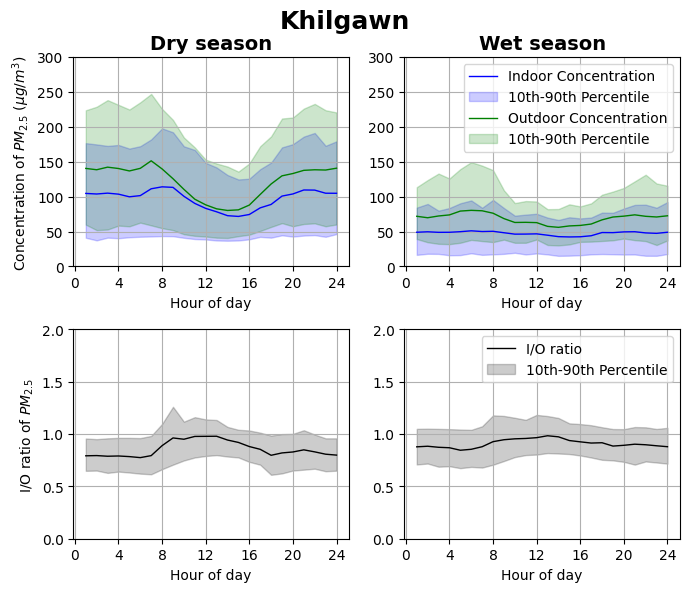

processing Dania Home


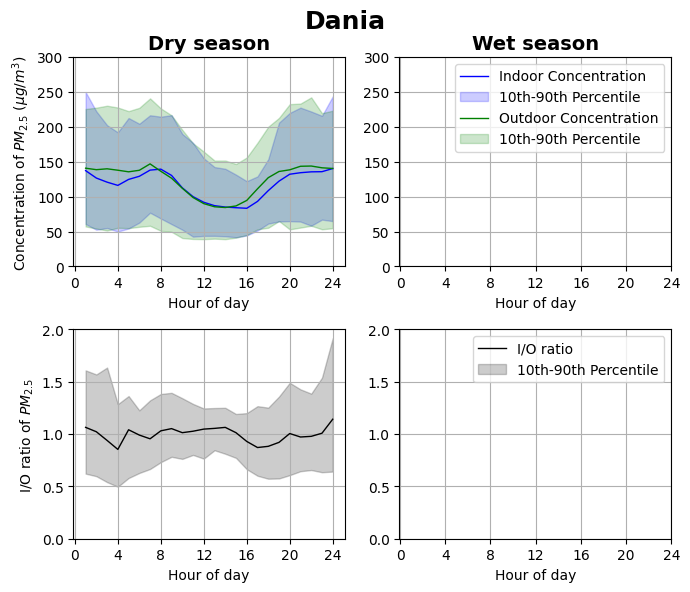

processing Badda Home


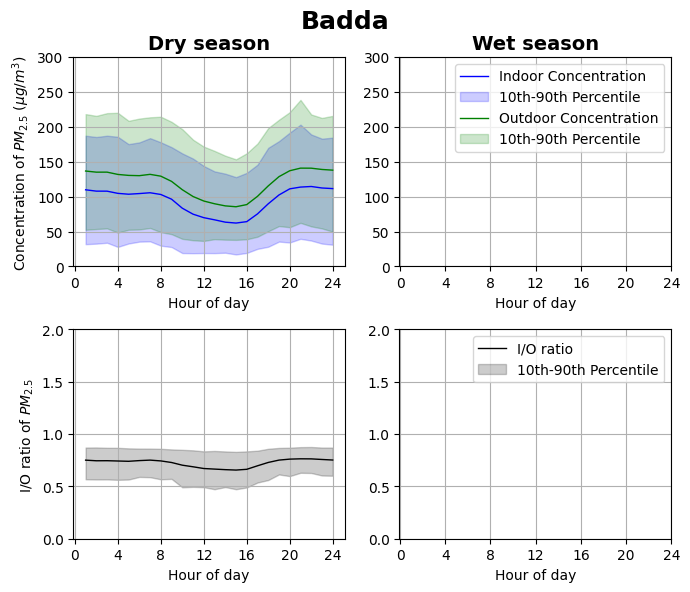

In [2]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/dinural variations/inout overlap'

# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"] + ["Dania Home", "Badda Home"]
# subdirs = ['Dhakeshwari Home']


for home in subdirs:
    print(f"processing {home}")
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']

    combined_df = pd.merge(indoor_df, outdoor_df, how='inner', on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0) else float('nan'))
    combined_df['hour'] = combined_df['time'].dt.hour  # Extract hour from time
    combined_df['hour'] = combined_df['hour'].apply(lambda x : x if x!=0 else 24)

    wet_df_combined = combined_df[combined_df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
    dry_df_combined = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    # Group by hour and calculate mean IO_ratio
    targets = [
        (
            'pm2_5_indoor', 
            in_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$ ($\mu g/m^{3}$)",
            "Indoor Concentration",
            'Concentrations'
        ), 
        (
            'pm2_5_outdoor', 
            out_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$ ($\mu g/m^{3}$)",
            "Outdoor Concentration",
            "Concentrations"
        ), 
        (
            'IO_ratio', 
            ratio_color, 
            (0, 2), 
            r"I/O ratio of $PM_{2.5}$",
            "I/O ratio",
            "Indoor/Outdoor ratio"
        )  
    ]


    fig, axes = plt.subplots(2, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [50, 50]})
    i = 0
    for target, color, ylim, ylabel, legend, item in targets:
        dinural_dry = dry_df_combined.groupby('hour')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(.10),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_wet = wet_df_combined.groupby('hour')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(0.1),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        if home in ["Dania Home", "Badda Home"]:
            dinural_wet['mean'] = np.nan
            dinural_wet['Q10'] = np.nan
            dinural_wet['Q90'] = np.nan
        j = 0
        for df, name  in [(dinural_dry, 'Dry'), (dinural_wet, 'Wet')]:
            if i > 0:
                ax = axes[i-1, j]
            else:
                ax = axes[i, j]

            # Plot the PM2.5 concentrations
            ax.plot(df['hour'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
            ax.fill_between(df['hour'], df['Q10'], df['Q90'], 
                    color=color, alpha=0.2, label='10th-90th Percentile')
            
            # Labels and title
            ax.set_xlabel('Hour of day')
            if j == 0:
                ax.set_ylabel(ylabel)
            if i == 0:
                ax.set_title(f'{name} season', fontsize = 14, fontweight = 'bold')
            if j == 1:
                ax.legend()
            ax.grid(True)
            # ax.set_xticklabels(ax.get_xticks(), rotation=45) 
            ax.set_ylim(ylim)
            ax.set_xticks(range(0, 25, 4))
            j += 1
        i += 1


    plt.suptitle(f'{home.split(' ')[0]}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)     
    plt.subplots_adjust(top=0.9)
 
    plt.savefig(os.path.join(savedir, f'{home.split(' ')[0]}.png'), dpi = 300)
    plt.show()


Processed Dhakeshwari Home
Processed Mohakhali Home
Processed Mohammadpur Home
Processed Banasree Home
Processed Nakhalpara Home
Processed Khilgawn Home
Processed Dania Home
Processed Badda Home


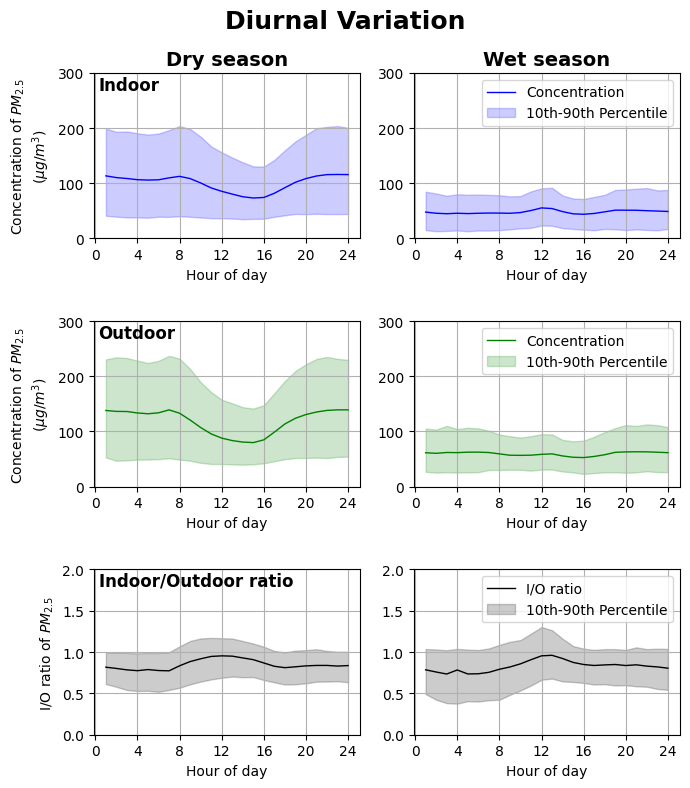

In [22]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/dinural variations'
# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"] + ["Dania Home", "Badda Home"]
indoor_dfs = []
outdoor_dfs = []
combined_dfs = []


for home in subdirs:
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']
    indoor_dfs.append(indoor_df)

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']
    outdoor_dfs.append(outdoor_df)

    combined_df = pd.merge(indoor_df, outdoor_df, how='inner', on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0) else float('nan'))
    combined_df['hour'] = combined_df['time'].dt.hour  # Extract hour from time
    combined_df['hour'] = combined_df['hour'].apply(lambda x : x if x!=0 else 24)
    if home in ["Dania Home", "Badda Home"]:
        combined_df = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])].copy()
    combined_dfs.append(combined_df)
    print(f"Processed {home}")

combined_df = pd.concat(combined_dfs)

wet_df_combined = combined_df[combined_df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
dry_df_combined = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
# Group by hour and calculate mean IO_ratio
targets = [
    (
        'pm2_5_indoor', 
        in_color, 
        (0, 300), 
        r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
        "Concentration",
        'Indoor'
    ), 
    (
        'pm2_5_outdoor', 
        out_color, 
        (0, 300), 
        r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
        "Concentration",
        "Outdoor"
    ), 
    (
        'IO_ratio', 
        ratio_color, 
        (0, 2), 
        r"I/O ratio of $PM_{2.5}$",
        "I/O ratio",
        "Indoor/Outdoor ratio"
    )  
]

home = "Full Data"
fig, axes = plt.subplots(3, 2, figsize=(7, 8), gridspec_kw={'width_ratios': [50, 50]})
i = 0
for target, color, ylim, ylabel, legend, item in targets:
    dinural_dry = dry_df_combined.groupby('hour')[target].agg(
                                                                        mean='mean',
                                                                        Q10=lambda x: x.quantile(.10),
                                                                        Q90=lambda x: x.quantile(0.9)
                                                                    ).reset_index()
    dinural_wet = wet_df_combined.groupby('hour')[target].agg(
                                                                        mean='mean',
                                                                        Q10=lambda x: x.quantile(0.1),
                                                                        Q90=lambda x: x.quantile(0.9)
                                                                    ).reset_index()

    j = 0
    for df, name  in [(dinural_dry, 'Dry'), (dinural_wet, 'Wet')]:
        ax = axes[i, j]

        # Plot the PM2.5 concentrations
        ax.plot(df['hour'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
        ax.fill_between(df['hour'], df['Q10'], df['Q90'], 
                color=color, alpha=0.2, label='10th-90th Percentile')
        
        # Labels and title
        ax.set_xlabel('Hour of day')
        if j == 0:
            ax.set_ylabel(ylabel)
        if i == 0:
            ax.set_title(f'{name} season', fontsize = 14, fontweight = 'bold')
        if j == 1:
            ax.legend()
        ax.grid(True)
        ax.set_xticks(range(0, 25, 4))
        # ax.set_xticklabels(ax.get_xticks(), rotation=45) 
        ax.set_ylim(ylim)
        if j == 0: ax.text(0.3, ylim[1] * .9, item, fontsize = 12, fontweight = "bold")
        j += 1
    i += 1


plt.suptitle(f'Diurnal Variation', fontsize = 18, fontweight = 'bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.5)     
plt.subplots_adjust(top=0.9)  # Adjust top spacing to move plots down

plt.savefig(os.path.join(savedir, f'fullData.png'), dpi = 300)
plt.show()

#### Weekly daywise variation

processing Dhakeshwari Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

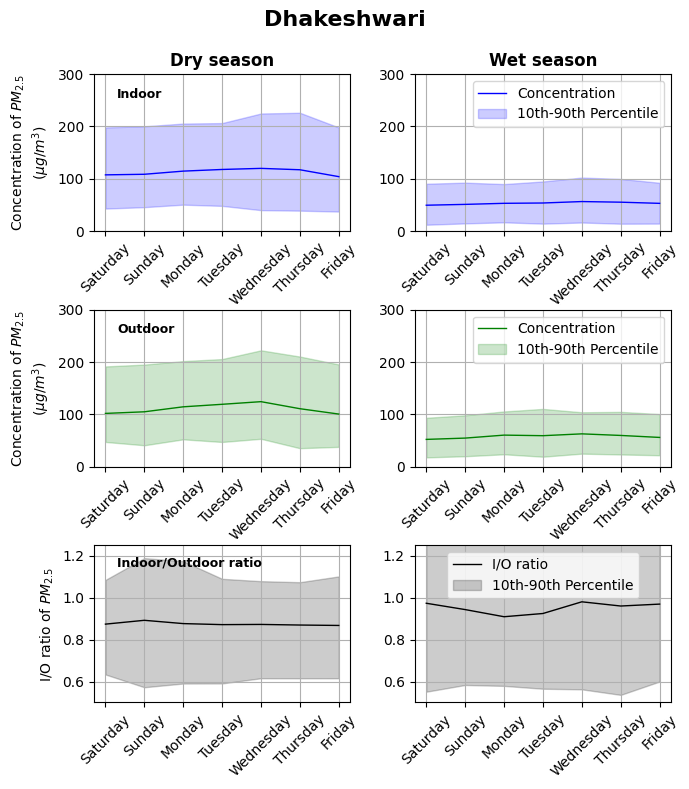

processing Mohakhali Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

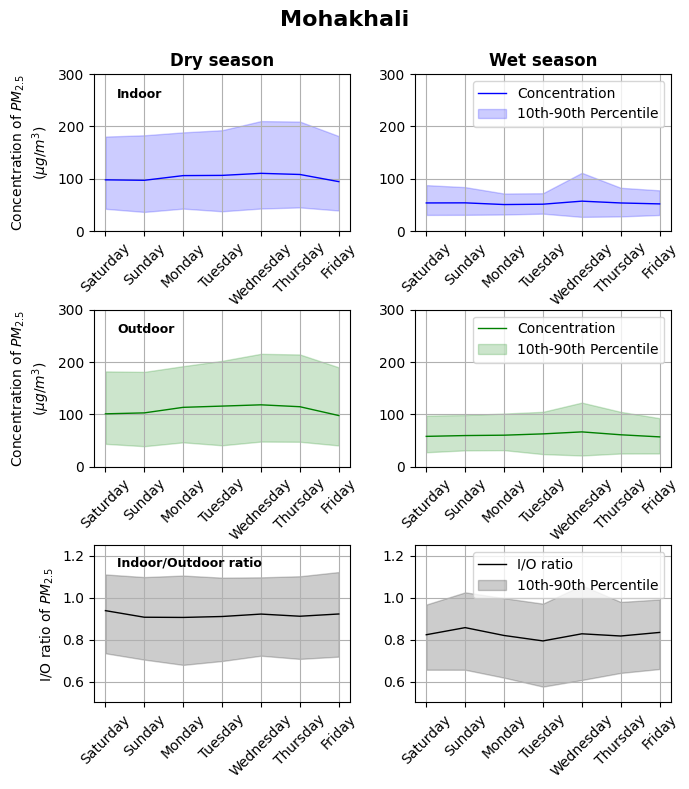

processing Mohammadpur Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

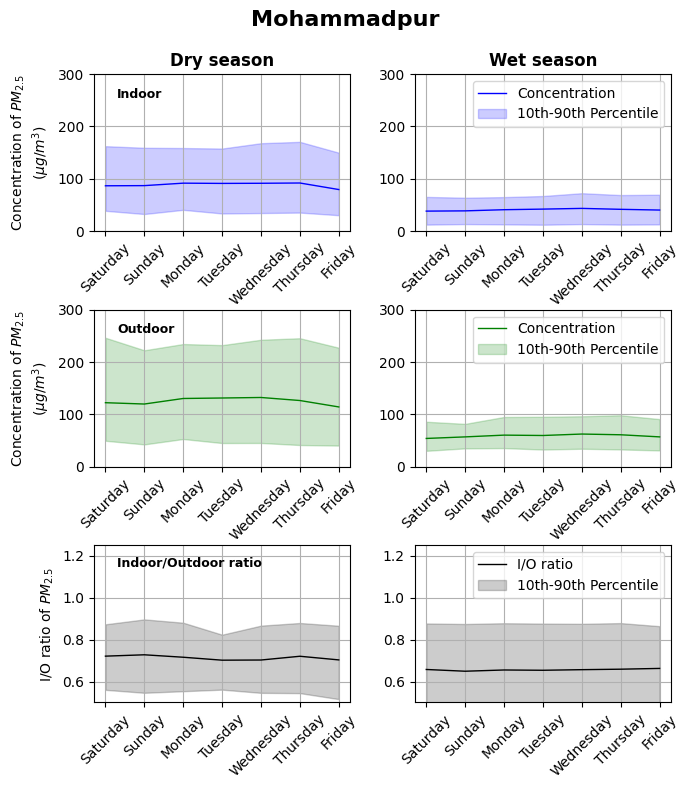

processing Banasree Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

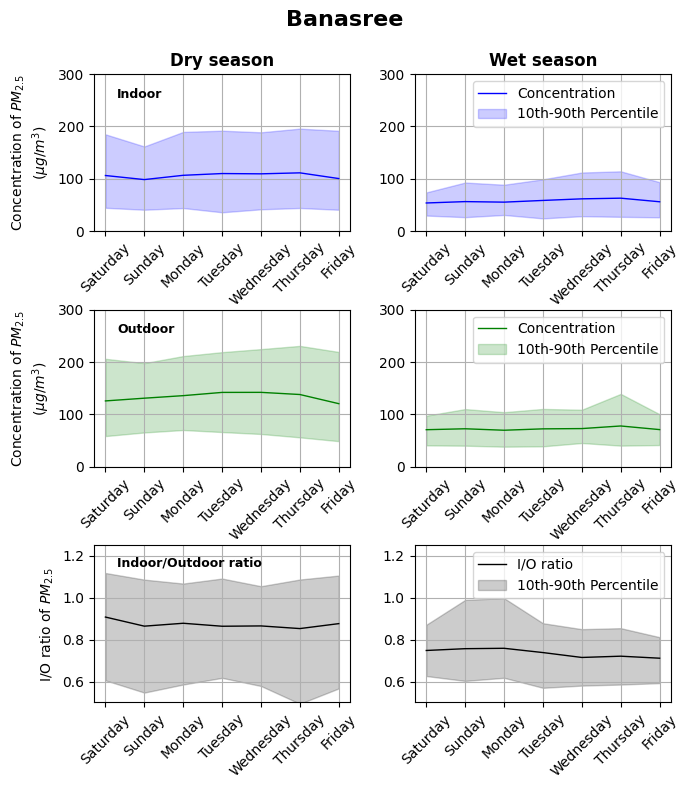

processing Nakhalpara Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

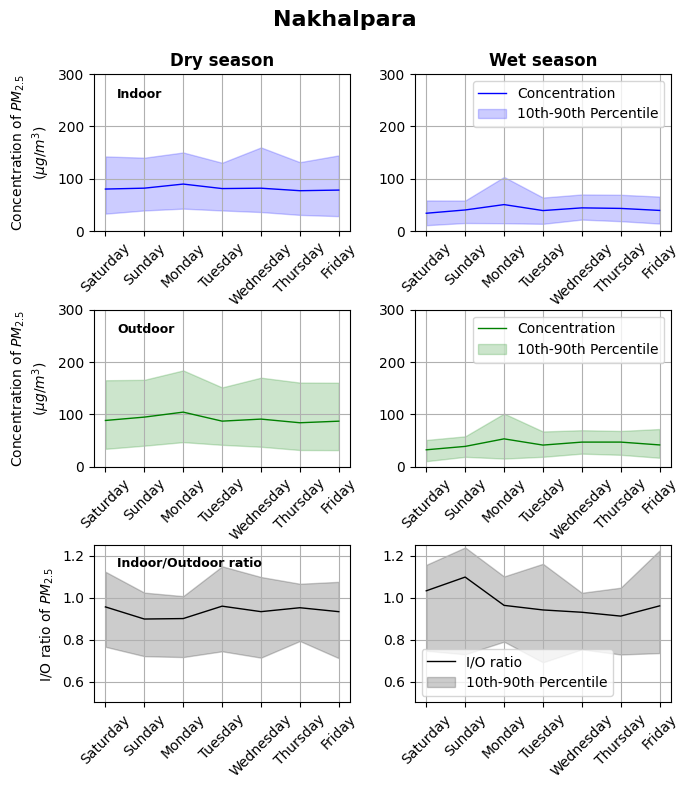

processing Khilgawn Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\3461393464.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotatio

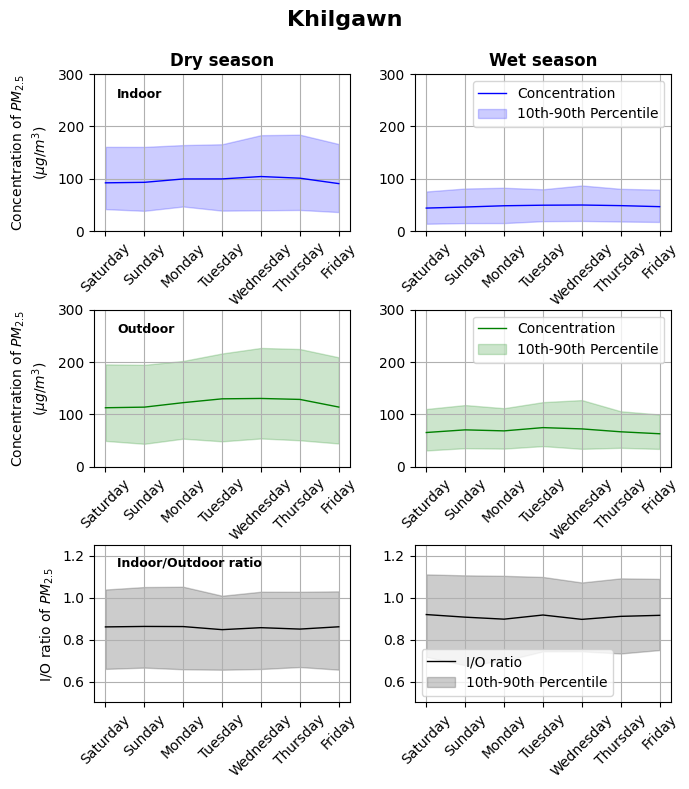

In [9]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/weekly variations'

# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"]
# subdirs = ['Dhakeshwari Home']


for home in subdirs:
    print(f"processing {home}")
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']

    combined_df = pd.merge(indoor_df, outdoor_df, how='inner', on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0) else float('nan'))
    combined_df['day_name'] = combined_df['time'].dt.day_name()  # Extract hour from time
    if home in ["Dania Home", "Badda Home"]:
        combined_df = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])].copy()


    wet_df_combined = combined_df[combined_df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
    dry_df_combined = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    # Group by hour and calculate mean IO_ratio
    targets = [
        (
            'pm2_5_indoor', 
            in_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
            "Concentration",
            'Indoor'
        ), 
        (
            'pm2_5_outdoor', 
            out_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
            "Concentration",
            "Outdoor"
        ), 
        (
            'IO_ratio', 
            ratio_color, 
            (0.5, 1.25), 
            r"I/O ratio of $PM_{2.5}$",
            "I/O ratio",
            "Indoor/Outdoor ratio"
        )  
    ]


    fig, axes = plt.subplots(3, 2, figsize=(7, 8), gridspec_kw={'width_ratios': [50, 50]})
    i = 0
    for target, color, ylim, ylabel, legend, item in targets:
        day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

        dinural_dry = dry_df_combined.groupby('day_name')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(.10),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_dry["day_name"] = pd.Categorical(dinural_dry["day_name"], categories=day_order, ordered=True)
        dinural_dry = dinural_dry.sort_values("day_name").reset_index(drop=True)
        dinural_wet = wet_df_combined.groupby('day_name')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(0.1),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_wet["day_name"] = pd.Categorical(dinural_wet["day_name"], categories=day_order, ordered=True)
        dinural_wet = dinural_wet.sort_values("day_name").reset_index(drop=True)

        j = 0
        for df, name  in [(dinural_dry, 'Dry'), (dinural_wet, 'Wet')]:
            ax = axes[i, j]

            # Plot the PM2.5 concentrations
            ax.plot(df['day_name'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
            ax.fill_between(df['day_name'], df['Q10'], df['Q90'], 
                    color=color, alpha=0.2, label='10th-90th Percentile')
            
            
            if j == 0:
                ax.set_ylabel(ylabel)
            if i == 0:
                ax.set_title(f'{name} season', fontsize = 12, fontweight = 'bold')
            if j == 1:
                ax.legend()
            ax.grid(True)
            ax.set_ylim(ylim)
            if j ==0: 
                if i == 2: ax.text(0.3, ylim[1] * .92, item, fontsize = 9, fontweight = 'bold')
                else: ax.text(0.3, ylim[1] * .85, item, fontsize = 9, fontweight = 'bold')
            ax.set_xticklabels(day_order, rotation = 45)
            j += 1
        i += 1


    plt.suptitle(f'{home.split(' ')[0]}', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.5)     
    plt.subplots_adjust(top=0.9)  # Adjust top spacing to move plots down
 
    plt.savefig(os.path.join(savedir, f'{home.split(' ')[0]}.png'), dpi = 300)
    plt.show()


In [ ]:
    i = 0
    for target, color, ylim, ylabel, legend, item in targets:
        day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

        dinural_dry = dry_df_combined.groupby('day_name')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(.10),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_dry["day_name"] = pd.Categorical(dinural_dry["day_name"], categories=day_order, ordered=True)
        dinural_dry = dinural_dry.sort_values("day_name").reset_index(drop=True)
        dinural_wet = wet_df_combined.groupby('day_name')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(0.1),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_wet["day_name"] = pd.Categorical(dinural_wet["day_name"], categories=day_order, ordered=True)
        dinural_wet = dinural_wet.sort_values("day_name").reset_index(drop=True)

        j = 0
        for df, name  in [(dinural_dry, 'Dry'), (dinural_wet, 'Wet')]:
            ax = axes[i, j]

            # Plot the PM2.5 concentrations
            ax.plot(df['day_name'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
            ax.fill_between(df['day_name'], df['Q10'], df['Q90'], 
                    color=color, alpha=0.2, label='10th-90th Percentile')
            
            
            if j == 0:
                ax.set_ylabel(ylabel)
            if i == 0:
                ax.set_title(f'{name} season', fontsize = 14, fontweight = 'bold')
            if j == 1:
                ax.legend()
            ax.grid(True)
            ax.set_ylim(ylim)
            ax.text(0.3, ylim[1] * .9, item, fontsize = 12, fontweight = "bold")
            ax.set_xticklabels(day_order, rotation = 45)
            j += 1
        i += 1


    plt.suptitle(f'{home.split(' ')[0]}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.3)     
    plt.subplots_adjust(top=0.9)  # Adjust top spacing to move plots down
 
    plt.savefig(os.path.join(savedir, f'{home.split(' ')[0]}.png'), dpi = 300)
    plt.show()


processing Dania Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)


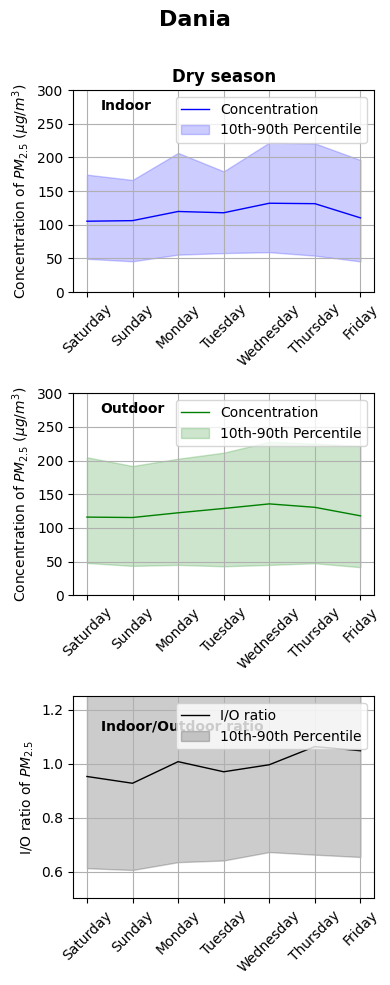

processing Badda Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1702075812.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_order, rotation = 45)


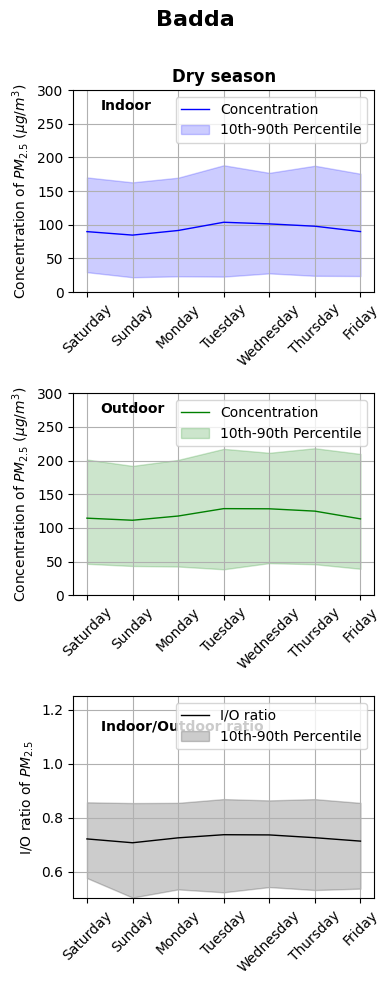

In [13]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/weekly variations'

# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dania Home", "Badda Home"]
# subdirs = ['Dhakeshwari Home']


for home in subdirs:
    print(f"processing {home}")
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']

    combined_df = pd.merge(indoor_df, outdoor_df, how='inner', on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0) else float('nan'))
    combined_df['day_name'] = combined_df['time'].dt.day_name()  # Extract hour from time
    if home in ["Dania Home", "Badda Home"]:
        combined_df = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])].copy()


    wet_df_combined = combined_df[combined_df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
    dry_df_combined = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    # Group by hour and calculate mean IO_ratio
    targets = [
        (
            'pm2_5_indoor', 
            in_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$ ($\mu g/m^{3}$)",
            "Concentration",
            'Indoor'
        ), 
        (
            'pm2_5_outdoor', 
            out_color, 
            (0, 300), 
            r"Concentration of $PM_{2.5}$ ($\mu g/m^{3}$)",
            "Concentration",
            "Outdoor"
        ), 
        (
            'IO_ratio', 
            ratio_color, 
            (0.5, 1.25), 
            r"I/O ratio of $PM_{2.5}$",
            "I/O ratio",
            "Indoor/Outdoor ratio"
        )  
    ]


    fig, axes = plt.subplots(3, 1, figsize=(4, 10))
    i = 0
    for target, color, ylim, ylabel, legend, item in targets:
        day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

        dinural_dry = dry_df_combined.groupby('day_name')[target].agg(
                                                                            mean='mean',
                                                                            Q10=lambda x: x.quantile(.10),
                                                                            Q90=lambda x: x.quantile(0.9)
                                                                        ).reset_index()
        dinural_dry["day_name"] = pd.Categorical(dinural_dry["day_name"], categories=day_order, ordered=True)
        dinural_dry = dinural_dry.sort_values("day_name").reset_index(drop=True)
    
        

        j = 0
        for df, name  in [(dinural_dry, 'Dry')]:
            ax = axes[i]

            # Plot the PM2.5 concentrations
            ax.plot(df['day_name'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
            ax.fill_between(df['day_name'], df['Q10'], df['Q90'], 
                    color=color, alpha=0.2, label='10th-90th Percentile')
            
            
            
            ax.set_ylabel(ylabel)
            if i == 0:
                ax.set_title(f'{name} season', fontsize = 12, fontweight = 'bold')
            
            ax.legend(loc="upper right")
            ax.grid(True)
            ax.set_ylim(ylim)
            ax.text(0.3, ylim[1] * .9, item, fontsize = 10, fontweight = "bold")
            ax.set_xticklabels(day_order, rotation = 45)
            j += 1
        i += 1


    plt.suptitle(f'{home.split(' ')[0]}', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.5)     
    plt.subplots_adjust(top=0.9)  # Adjust top spacing to move plots down
 
    plt.savefig(os.path.join(savedir, f'{home.split(' ')[0]}.png'), dpi = 300)
    plt.show()


Processed Dhakeshwari Home
Processed Mohakhali Home
Processed Mohammadpur Home
Processed Banasree Home
Processed Nakhalpara Home
Processed Khilgawn Home
Processed Dania Home
Processed Badda Home
I/O ratio dry : 0.847288847524851 +- 0.2538451883317506
I/O ratio wet : 0.8297328625385735 +- 0.4018766867060887


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1622193848.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  if i == 2: ax.set_xticklabels(day_order, rotation = 45)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_7272\1622193848.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  if i == 2: ax.set_xticklabels(day_order, rotation = 45)


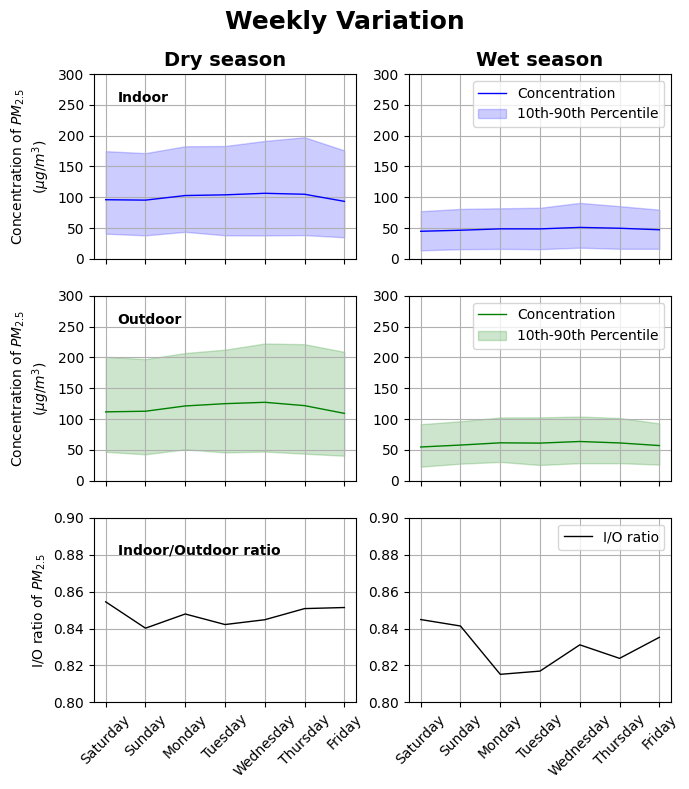

In [30]:
## I/O Time dinural (full)
## plotting

dir = 'Data/Raw Clone'
savedir = 'graphs/weekly variations'

# subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"] + ["Dania Home", "Badda Home"]
indoor_dfs = []
outdoor_dfs = []
combined_dfs = []


for home in subdirs:
    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Indoor.csv')
    indoor_df['time'] = pd.to_datetime(indoor_df['time'])
    indoor_df = indoor_df[['time', 'pm2_5_atm_calibrated']]
    indoor_df.columns = ['time', 'pm2_5_indoor']
    indoor_dfs.append(indoor_df)

    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Hourly_average_merged_calibrated_Outdoor.csv')
    outdoor_df['time'] = pd.to_datetime(outdoor_df['time'])
    outdoor_df = outdoor_df[['time', 'pm2_5_atm_calibrated']]
    outdoor_df.columns = ['time', 'pm2_5_outdoor']
    outdoor_dfs.append(outdoor_df)

    combined_df = pd.merge(indoor_df, outdoor_df, how='inner', on='time')
    combined_df['IO_ratio'] = combined_df['pm2_5_indoor'] / combined_df['pm2_5_outdoor']
    combined_df['IO_ratio'] = combined_df['IO_ratio'].apply(lambda x : x if (x>0) else float('nan'))
    combined_df['day_name'] = combined_df['time'].dt.day_name()
    if home in ["Dania Home", "Badda Home"]:
        combined_df = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])].copy()
    combined_dfs.append(combined_df)
    print(f"Processed {home}")

combined_df = pd.concat(combined_dfs)


wet_df_combined = combined_df[combined_df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
dry_df_combined = combined_df[combined_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]

wet_io = wet_df_combined['IO_ratio']

dry_io = dry_df_combined['IO_ratio']

print(f"I/O ratio dry : {np.mean(dry_io)} +- {np.std(dry_io)}")
print(f'I/O ratio wet : {np.mean(wet_io)} +- {np.std(wet_io)}')
# Group by hour and calculate mean IO_ratio
targets = [
    (
        'pm2_5_indoor', 
        in_color, 
        (0, 300), 
        r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
        "Concentration",
        'Indoor'
    ), 
    (
        'pm2_5_outdoor', 
        out_color, 
        (0, 300), 
        r"Concentration of $PM_{2.5}$" + "\n" + r"($\mu g/m^{3}$)",
        "Concentration",
        "Outdoor"
    ), 
    (
        'IO_ratio', 
        ratio_color, 
        (0.8, 0.9), 
        r"I/O ratio of $PM_{2.5}$",
        "I/O ratio",
        "Indoor/Outdoor ratio"
    )  
]

home = "Full Data"
fig, axes = plt.subplots(3, 2, figsize=(7, 8), gridspec_kw={'width_ratios': [50, 50]})

i = 0
for target, color, ylim, ylabel, legend, item in targets:
    day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    dinural_dry = dry_df_combined.groupby('day_name')[target].agg(
                                                                        mean='mean',
                                                                        Q10=lambda x: x.quantile(.10),
                                                                        Q90=lambda x: x.quantile(0.9)
                                                                    ).reset_index()
    dinural_dry["day_name"] = pd.Categorical(dinural_dry["day_name"], categories=day_order, ordered=True)
    dinural_dry = dinural_dry.sort_values("day_name").reset_index(drop=True)
    dinural_wet = wet_df_combined.groupby('day_name')[target].agg(
                                                                        mean='mean',
                                                                        Q10=lambda x: x.quantile(0.1),
                                                                        Q90=lambda x: x.quantile(0.9)
                                                                    ).reset_index()
    dinural_wet["day_name"] = pd.Categorical(dinural_wet["day_name"], categories=day_order, ordered=True)
    dinural_wet = dinural_wet.sort_values("day_name").reset_index(drop=True)

    j = 0
    for df, name  in [(dinural_dry, 'Dry'), (dinural_wet, 'Wet')]:
        ax = axes[i, j]

        # Plot the PM2.5 concentrations
        ax.plot(df['day_name'], df['mean'], label=legend, color=color, linestyle='-', markersize=3, linewidth = 1)
        if target != 'IO_ratio': ax.fill_between(df['day_name'], df['Q10'], df['Q90'], 
                color=color, alpha=0.2, label='10th-90th Percentile')
        
        # Labels and title
        # ax.set_xlabel('Hour of day')
        if j == 0:
            ax.set_ylabel(ylabel)
        if i == 0:
            ax.set_title(f'{name} season', fontsize = 14, fontweight = 'bold')
        if j == 1:
            ax.legend()
        ax.grid(True)
        # ax.set_xticklabels(ax.get_xticks(), rotation=45) 
        ax.set_ylim(ylim)
        if i == 2: ax.set_xticklabels(day_order, rotation = 45)
        else: ax.set_xticklabels([])
        x = list(range(1, 8))
        y = df['mean']
        # for k in range(len(x)):
        #     ax.annotate(f"{y[k]:.2f}", (x[k], y[k]), textcoords="offset points", xytext=(6,6), ha='right')

        if j == 0: 
            if i != 2: ax.text(0.3, ylim[1] * .85, item, fontsize = 10, fontweight = "bold")
            else: ax.text(0.3, 0.88, item, fontsize = 10, fontweight = "bold")
        j += 1
    i += 1

plt.suptitle(f'Weekly Variation', fontsize = 18, fontweight = 'bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)     
plt.subplots_adjust(top=0.9)  # Adjust top spacing to move plots down

plt.savefig(os.path.join(savedir, f'fullData.png'), dpi = 300)
plt.show()

In [14]:
j

1

#### Summay in table


In [ ]:
Home = []
mean_in_dry = []
mean_out_dry = []
ratio_wet = []
mean_in_wet = []
mean_out_wet = []
ratio_dry = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    Home.append(subdir)
    files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
    in_dry_mean = 0
    out_dry_mean = 0
    in_wet_mean = 0
    out_wet_mean = 0
    for file in files:
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        dry_mean = np.mean(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        wet_mean = np.mean(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        if type == "Indoor":
            in_dry_mean=dry_mean
            in_wet_mean=wet_mean
        else:
            out_dry_mean=dry_mean
            out_wet_mean=wet_mean
    
    dry_ratio = in_dry_mean/out_dry_mean
    wet_ratio = in_wet_mean/out_wet_mean
    mean_in_dry.append(in_dry_mean)
    mean_out_dry.append(out_dry_mean)
    ratio_wet.append(wet_ratio)
    mean_in_wet.append(in_wet_mean)
    mean_out_wet.append(out_wet_mean)
    ratio_dry.append(dry_ratio)

datas = {"Home" : Home,
 "Indoor conc for dry season"  : mean_in_dry,
 "Outdoor conc for dry season" : mean_out_dry,
 "I/O ratio dry" : ratio_dry,
 "Indoor conc for wet season"  : mean_in_wet,
 "Outdoor conc for wet season" : mean_out_wet,
 "I/O ratio wet" : ratio_wet}

pd.DataFrame(datas)


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home


,Home,Indoor conc for dry season,Outdoor conc for dry season,I/O ratio dry,Indoor conc for wet season,Outdoor conc for wet season,I/O ratio wet
0,Dhakeshwari Home,112.842384,110.938805,1.017159,53.166282,57.963203,0.917242
1,Mohakhali Home,99.428623,109.254786,0.910062,43.446852,60.715137,0.715585
2,Mohammadpur Home,88.477764,120.030630,0.737127,40.700721,58.846469,0.691643
3,Banasree Home,106.055426,133.551528,0.794116,57.737996,72.471844,0.796696
4,Nakhalpara Home,81.463696,90.935958,0.895836,41.718847,43.154657,0.966729
5,Khilgawn Home,97.258991,121.653471,0.799476,48.435919,68.733728,0.704689
6,Dania Home,99.242935,123.838429,0.801390,46.778239,55.425417,0.843985
7,Badda Home,94.125528,114.682726,0.820747,35.056654,53.601098,0.654029


### Hourly Average plots

  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1636136659.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  dry_plot = ax[0, 0].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=dry_positions[0:-4] + [x+.5 for x in dry_positions[-4:]], showmeans = True)


  0%|          | 0/6 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1636136659.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  wet_plot = ax[0, 1].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=wet_positions, showmeans = True)


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1636136659.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[1, 0].boxplot(dryboxPlotArray, labels=[x.split(' ')[0] for x in dryboxPlotLabel], showfliers=False, positions = [1, 2, 3, 4, 5, 6, 7.5, 8.5], showmeans = True)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1636136659.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[1, 1].boxplot(wetboxPlotArray, labels=[x.split(' ')[0] for x in wetboxPlotLabel], showfliers=False, showmeans = True)


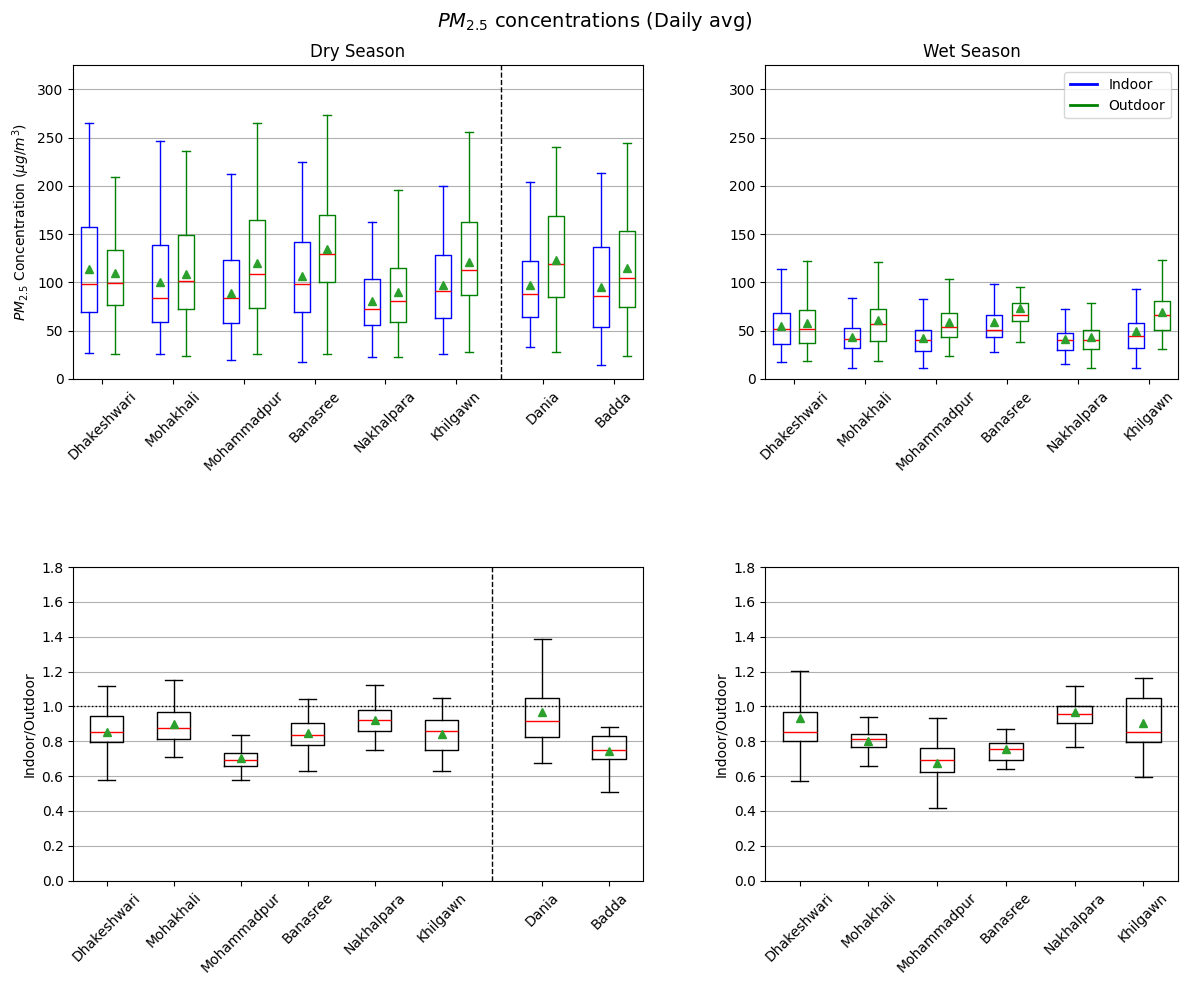

In [9]:
boxPlotArray = []
boxPlotLabel = []

# Define alternating colors
colors = ["blue", "green"]  # You can customize these colors
color_cycle = itertools.cycle(colors)  # Create an alternating cycle

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

for subdir in tqdm(subdirs):

    print(f'Processing {subdir}')
    files = ['Daily_average_merged_calibrated_Indoor.csv', 'Daily_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        # wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        dry = np.concatenate(dry)
        # wet = np.concatenate(wet)

        boxPlotArray.append(dry)
        # boxPlotArray.append(wet)

        boxPlotLabel.append(f'{type}_{subdir}')
        # boxPlotLabel.append(f'Wet_{type}_{subdir}')
        

# Create a boxplot for the four categories
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [58, 42]}) 

# Plot Dry Season
dry_positions = generate_positions(len(boxPlotArray) // 2)
dry_plot = ax[0, 0].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=dry_positions[0:-4] + [x+.5 for x in dry_positions[-4:]], showmeans = True)
set_box_outline_colors(dry_plot, colors)
ax[0, 0].axvline(x = 13.8, color='black', linestyle='--', linewidth = 1)
ax[0, 0].set_title("Dry Season", fontsize = 12)
ax[0, 0].set_ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].grid(True, axis = 'y')
ax[0, 0].set_ylim((0, 325))

positions = [1.4+x*2.2 for x in range(8)]
positions = positions[0:-2] + [x+.5 for x in positions[-2:]]
labels = [x.split(' ')[0].split('_')[1] for x in boxPlotLabel[0::2]]

# Apply to your subplot
ax[0, 0].set_xticks(positions)        # Fix tick positions
ax[0, 0].set_xticklabels(labels, rotation = 45)      # Set custom labels




########################################
boxPlotArray = []
boxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"]
for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    files = ['Daily_average_merged_calibrated_Indoor.csv', 'Daily_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        # dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        # dry = np.concatenate(dry)
        wet = np.concatenate(wet)

        # boxPlotArray.append(dry)
        boxPlotArray.append(wet)

        # boxPlotLabel.append(f'Dry_{type}_{subdir}')
        boxPlotLabel.append(f'{type}_{subdir}')


# Plot Wet Season
wet_positions = generate_positions(len(boxPlotArray) // 2)
wet_plot = ax[0, 1].boxplot(boxPlotArray, labels=boxPlotLabel, showfliers=False, positions=wet_positions, showmeans = True)
set_box_outline_colors(wet_plot, colors)
ax[0,1].set_title("Wet Season", fontsize = 12)
# ax[1].set_ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
ax[0,1].tick_params(axis='x', rotation=90)
ax[0,1].grid(True, axis = 'y')
ax[0,1].set_ylim((0, 325))


positions = [1.4+x*2.2 for x in range(6)]
labels = [x.split(' ')[0].split('_')[1] for x in boxPlotLabel[0::2]]

# Apply to your subplot
ax[0,1].set_xticks(positions)        # Fix tick positions
ax[0,1].set_xticklabels(labels, rotation = 45)      # Set custom labels

Indoor = mlines.Line2D([], [], color="blue", linewidth=2, label="Indoor")
Outdoor = mlines.Line2D([], [], color="green", linewidth=2, label="Outdoor")


ax[0,1].legend(handles=[Indoor, Outdoor],
                     loc="upper right", ncols = 1)

##############################################
########################
dryboxPlotArray = []
dryboxPlotLabel = []

wetboxPlotArray = []
wetboxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

for subdir in tqdm(subdirs):
    # ['Daily_average_merged_calibrated_Indoor.csv', 'Daily_average_merged_calibrated_Outdoor.csv']
    print(f'Processing {subdir}')
    indoor_df =  pd.read_csv(os.path.join(dir, subdir, 'Daily_average_merged_calibrated_Indoor.csv'), parse_dates=['time'])
    indoor_df.columns = ['in_' + col if col != 'time' else col for col in indoor_df.columns]
    outdoor_df = pd.read_csv(os.path.join(dir, subdir, 'Daily_average_merged_calibrated_Outdoor.csv'), parse_dates=['time'])
    outdoor_df.columns = ['out_' + col if col != 'time' else col for col in outdoor_df.columns]

    merged_df = pd.merge(indoor_df, outdoor_df, on='time', how='inner')
    merged_df = merged_df.dropna(subset=['out_pm2_5_atm_calibrated', 'in_pm2_5_atm_calibrated'])
    merged_df['io_ratio'] = merged_df['in_pm2_5_atm_calibrated'] / merged_df['out_pm2_5_atm_calibrated']

    # merged_df = merged_df[merged_df['io_ratio'] < 5]
    dry_season = merged_df[merged_df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    wet_season = merged_df[merged_df['time'].dt.month.isin([4,5, 6, 7, 8, 9])]

    dryboxPlotArray.append(dry_season['io_ratio'].to_numpy())
    dryboxPlotLabel.append(f'{subdir}')

    wetboxPlotArray.append(wet_season['io_ratio'].to_numpy())
    wetboxPlotLabel.append(f'{subdir}')

wetboxPlotArray = wetboxPlotArray[0:-2]
wetboxPlotLabel = wetboxPlotLabel[0:-2]   


# Create a boxplot for the four categories

box = ax[1, 0].boxplot(dryboxPlotArray, labels=[x.split(' ')[0] for x in dryboxPlotLabel], showfliers=False, positions = [1, 2, 3, 4, 5, 6, 7.5, 8.5], showmeans = True)
ax[1, 0].axvline(x = 6.75, color='black', linestyle='--', linewidth = 1)
ax[1, 0].axhline(y=1, color='black', linestyle='dotted', linewidth=1)  # Horizontal dashed line at y=1
ax[1, 0].set_ylabel(r'Indoor/Outdoor')  # Corrected method for ylabel
ax[1, 0].tick_params(axis='x', rotation=45)  # Corrected x-axis rotation
ax[1, 0].grid(axis='y')  # Grid only for y-direction
ax[1, 0].set_ylim((0, 1.8))  # Corrected method for setting y-axis limits

for median in box['medians']:  # Make median lines black for contrast
        median.set(color="red")

# Create a boxplot for the four categories

ax[1, 1].axhline(y=1, color='black', linestyle='dotted', linewidth=1)  # Horizontal dashed line at y=1
box = ax[1, 1].boxplot(wetboxPlotArray, labels=[x.split(' ')[0] for x in wetboxPlotLabel], showfliers=False, showmeans = True)
ax[1, 1].set_ylabel(r'Indoor/Outdoor')  # Corrected method for ylabel
ax[1, 1].tick_params(axis='x', rotation=45)  # Corrected method for rotating x-axis labels
ax[1, 1].grid(axis='y')  # Grid only in the y-direction
ax[1, 1].set_ylim((0, 1.8))  # Corrected method for setting y-axis limits

for median in box['medians']:  # Make median lines black for contrast
        median.set(color="red")




# Add a main title
fig.suptitle(r"$PM_{2.5}$ concentrations (Daily avg)", fontsize = 14)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.6)
plt.savefig('graphs/box plots/concentration dry wet & ratio_daily_avg.png', dpi = 300)
plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1514179753.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ind_plot = plt.boxplot(inboxPlotArray, labels=inboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_25812\1514179753.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  outd_plot = plt.boxplot(outboxPlotArray, labels=outboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)


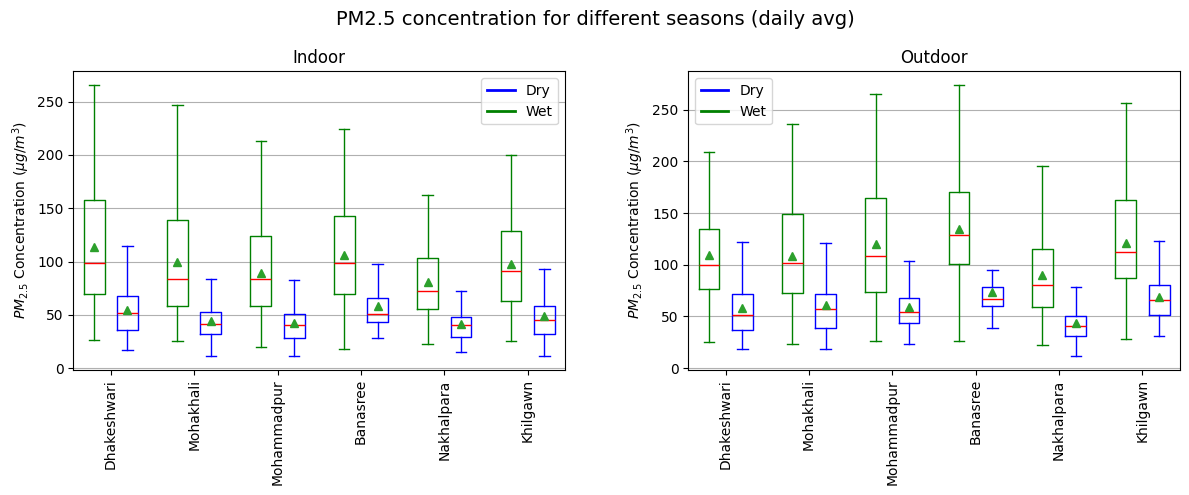

In [10]:
inboxPlotArray = []
inboxPlotLabel = []

outboxPlotArray = []
outboxPlotLabel = []

dir = 'Data/Raw Clone'
# subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home"]
for subdir in tqdm(subdirs):
    print(f'Processing {subdir}')
    files = ['Daily_average_merged_calibrated_Indoor.csv', 'Daily_average_merged_calibrated_Outdoor.csv']
    for file in files:
        dry = []
        wet = []
        if "tdoor" in file:
            type = 'Outdoor'
        elif "ndoor" in file:
            type = 'Indoor'
        else:
            warnings.warn("type not detected", UserWarning)
        # Load the DataFrame from CSV
        file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Define dry season (November to April) and wet season (May to October)
        dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
        wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
        
        
        dry.append(dry_season['pm2_5_atm_calibrated'].dropna().to_numpy())
        wet.append(wet_season['pm2_5_atm_calibrated'].dropna().to_numpy())

        dry = np.concatenate(dry)
        wet = np.concatenate(wet)

        if type == "Indoor":
            inboxPlotArray.append(dry)
            inboxPlotArray.append(wet)

            inboxPlotLabel.append(f'Dry_{subdir}')
            inboxPlotLabel.append(f'Wet_{subdir}')

        elif type == "Outdoor":
            outboxPlotArray.append(dry)
            outboxPlotArray.append(wet)

            outboxPlotLabel.append(f'Dry_{subdir}')
            outboxPlotLabel.append(f'Wet_{subdir}')
        
colors = ['green', 'blue']

# Create a boxplot for the four categories
plt.figure(figsize=(12, 5))
plt.subplots_adjust( wspace=0.3)  
plt.subplot(1, 2, 1)
ind_plot = plt.boxplot(inboxPlotArray, labels=inboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
plt.xticks([1.4, 3.4, 5.4, 7.4, 9.4, 11.4], labels=[x.split(' ')[0].split('_')[1] for x in inboxPlotLabel[0::2]])
set_box_outline_colors(ind_plot, colors)
plt.title("Indoor", fontsize = 12)
plt.ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(True, axis='y')

dry = mlines.Line2D([], [], color="blue", linewidth=2, label="Dry")
wet = mlines.Line2D([], [], color="green", linewidth=2, label="Wet")


legend2 = plt.legend(handles=[dry, wet],
                      ncols = 1)

# Create a boxplot for the four categories
plt.subplot(1, 2, 2)
outd_plot = plt.boxplot(outboxPlotArray, labels=outboxPlotLabel,  showfliers=False, positions=[1, 1.8, 3, 3.8, 5, 5.8, 7, 7.8, 9, 9.8, 11, 11.8], showmeans=True)
set_box_outline_colors(outd_plot, colors)
plt.title("Outdoor", fontsize = 12)
plt.xticks([1.4, 3.4, 5.4, 7.4, 9.4, 11.4], labels=[x.split(' ')[0].split('_')[1] for x in outboxPlotLabel[0::2]])
plt.ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(True, axis='y')
plt.suptitle('PM2.5 concentration for different seasons (daily avg)', fontsize = 14)

dry = mlines.Line2D([], [], color="blue", linewidth=2, label="Dry")
wet = mlines.Line2D([], [], color="green", linewidth=2, label="Wet")


legend2 = plt.legend(handles=[dry, wet],
                      ncols = 1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('graphs/box plots/conc indoor outdoor.png', dpi = 300)
plt.show()



In [31]:
datas = [
    ('current_humidity', 'humidity'),
    ('current_temp_f', 'temperature'),
    ('current_dewpoint_f', 'dewpoint'),
    ('pressure', 'pressure')
         ]
for data, name in datas:
    Home = []
    mean_in_dry = []
    mean_out_dry = []
    ratio_wet = []
    mean_in_wet = []
    mean_out_wet = []
    ratio_dry = []

    dir = 'Data/Raw Clone'
    # subdirs = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f)) if "Home" in f]
    subdirs = ["Dhakeshwari Home", "Mohakhali Home", "Mohammadpur Home", "Banasree Home", "Nakhalpara Home", "Khilgawn Home", "Dania Home", "Badda Home"]

    for subdir in tqdm(subdirs):
        print(f'Processing {subdir}')
        Home.append(subdir)
        files = ['Hourly_average_merged_calibrated_Indoor.csv', 'Hourly_average_merged_calibrated_Outdoor.csv']
        in_dry_mean = 0
        out_dry_mean = 0
        in_wet_mean = 0
        out_wet_mean = 0
        for file in files:
            if "tdoor" in file:
                type = 'Outdoor'
            elif "ndoor" in file:
                type = 'Indoor'
            else:
                warnings.warn("type not detected", UserWarning)
            # Load the DataFrame from CSV
            file_path = os.path.join(dir, subdir, file)  # Replace with your actual file path
            df = pd.read_csv(file_path)

            # Ensure the 'time' column is in datetime format
            df['time'] = pd.to_datetime(df['time'])

            # Define dry season (November to April) and wet season (May to October)
            dry_season = df[df['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]
            wet_season = df[df['time'].dt.month.isin([4, 5, 6, 7, 8, 9])]
            dry_mean = np.mean(dry_season[data].dropna().to_numpy())
            wet_mean = np.mean(wet_season[data].dropna().to_numpy())
            if type == "Indoor":
                in_dry_mean=dry_mean
                in_wet_mean=wet_mean
            else:
                out_dry_mean=dry_mean
                out_wet_mean=wet_mean
        
        if subdir in ['Dania Home', 'Badda Home']:
            in_wet_mean = float('nan')
            out_wet_mean = float('nan')
            wet_ratio = float('nan')
        
        dry_ratio = in_dry_mean/out_dry_mean
        wet_ratio = in_wet_mean/out_wet_mean
        mean_in_dry.append(in_dry_mean)
        mean_out_dry.append(out_dry_mean)
        ratio_dry.append(dry_ratio)
        mean_in_wet.append(in_wet_mean)
        mean_out_wet.append(out_wet_mean)
        ratio_wet.append(wet_ratio)

    Home += ["mean", "std"]
    mean_in_dry += [np.nanmean(mean_in_dry), np.nanstd(mean_in_dry)]
    print(f"{name} dry indoor: {np.nanmean(mean_in_dry):.2f} +- {np.nanstd(mean_in_dry):.2f}")
    mean_in_wet += [np.nanmean(mean_in_wet), np.nanstd(mean_in_wet)]
    print(f"{name} wet indoor: {np.nanmean(mean_in_wet):.2f} +- {np.nanstd(mean_in_wet):.2f}")

    mean_out_dry += [np.nanmean(mean_out_dry), np.nanstd(mean_out_dry)]
    print(f"{name} dry outdoor: {np.nanmean(mean_out_dry):.2f} +- {np.nanstd(mean_out_dry):.2f}")
    mean_out_wet += [np.nanmean(mean_out_wet), np.nanstd(mean_out_wet)]
    print(f"{name} wet outdoor: {np.nanmean(mean_out_wet):.2f} +- {np.nanstd(mean_out_wet):.2f}")
    ratio_dry += [np.nanmean(ratio_dry), np.nanstd(ratio_dry)]
    ratio_wet += [np.nanmean(ratio_wet), np.nanstd(ratio_wet)]

    datas = {"Home" : Home,
    f"Indoor {name} for dry season"  : mean_in_dry,
    f"Outdoor {name} for dry season" : mean_out_dry,
    f"I/O ratio dry" : ratio_dry,
    f"Indoor {name} for wet season"  : mean_in_wet,
    f"Outdoor {name} for wet season" : mean_out_wet,
    f"I/O ratio wet" : ratio_wet}

    print(f'Datatable for {name}')
    df = pd.DataFrame(datas)
    display(df)
    df.to_csv(f'Documents/summaries/{data}.csv', index = False)
    



  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home
humidity dry indoor: 42.97 +- 13.94
humidity wet indoor: 49.62 +- 17.77
humidity dry outdoor: 46.84 +- 14.63
humidity wet outdoor: 55.22 +- 19.14
Datatable for humidity


,Home,Indoor humidity for dry season,Outdoor humidity for dry season,I/O ratio dry,Indoor humidity for wet season,Outdoor humidity for wet season,I/O ratio wet
0,Dhakeshwari Home,49.360441,64.652396,0.763474,61.336396,82.055436,0.747499
1,Mohakhali Home,46.183385,46.318334,0.997086,51.482899,53.327227,0.965415
2,Mohammadpur Home,45.618671,51.405609,0.887426,53.998267,59.421600,0.908731
3,Banasree Home,48.520731,48.223296,1.006168,56.047118,55.589581,1.008231
4,Nakhalpara Home,46.480697,51.007778,0.911247,56.051343,61.109462,0.917229
5,Khilgawn Home,48.068999,51.187922,0.939069,58.616073,59.088830,0.991999
6,Dania Home,47.614213,52.606026,0.905109,NaN,NaN,NaN
7,Badda Home,48.938242,46.072641,1.062197,NaN,NaN,NaN
8,mean,47.598173,51.434250,0.933972,56.255349,61.765356,0.923184
9,std,1.281758,5.495060,0.085329,3.144989,9.435012,0.086469


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home
temperature dry indoor: 78.42 +- 25.49
temperature wet indoor: 82.66 +- 30.96
temperature dry outdoor: 75.58 +- 24.58
temperature wet outdoor: 79.96 +- 28.19
Datatable for temperature


,Home,Indoor temperature for dry season,Outdoor temperature for dry season,I/O ratio dry,Indoor temperature for wet season,Outdoor temperature for wet season,I/O ratio wet
0,Dhakeshwari Home,85.893937,80.146024,1.071718,93.398186,74.203915,1.258669
1,Mohakhali Home,85.857155,84.792411,1.012557,95.234910,94.144487,1.011582
2,Mohammadpur Home,88.267231,84.593035,1.043434,94.760893,93.260264,1.016091
3,Banasree Home,87.331268,83.365166,1.047575,94.770182,94.945060,0.998158
4,Nakhalpara Home,91.147009,87.764154,1.038545,94.760633,93.199474,1.016751
5,Khilgawn Home,87.589910,83.616080,1.047525,93.249193,92.295843,1.010329
6,Dania Home,85.832797,82.335778,1.042473,NaN,NaN,NaN
7,Badda Home,83.206141,83.436928,0.997234,NaN,NaN,NaN
8,mean,86.890681,83.756197,1.037633,94.362333,90.341507,1.051930
9,std,2.163645,2.036025,0.021440,0.754308,7.263881,0.092658


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home
dewpoint dry indoor: 57.77 +- 18.76
dewpoint wet indoor: 66.55 +- 24.76
dewpoint dry outdoor: 56.69 +- 18.26
dewpoint wet outdoor: 65.54 +- 23.77
Datatable for dewpoint


,Home,Indoor dewpoint for dry season,Outdoor dewpoint for dry season,I/O ratio dry,Indoor dewpoint for wet season,Outdoor dewpoint for wet season,I/O ratio wet
0,Dhakeshwari Home,63.980547,65.369513,0.978752,77.640661,68.222394,1.138052
1,Mohakhali Home,62.251500,60.503498,1.028891,74.127283,73.447893,1.009250
2,Mohammadpur Home,64.009170,63.743246,1.004172,74.985870,76.313205,0.982607
3,Banasree Home,65.168486,61.257907,1.063838,76.344790,76.262300,1.001082
4,Nakhalpara Home,67.203091,66.606598,1.008955,76.257065,77.261391,0.987001
5,Khilgawn Home,64.810882,62.467381,1.037516,76.069556,75.330379,1.009812
6,Dania Home,63.140510,62.231158,1.014612,NaN,NaN,NaN
7,Badda Home,61.444537,59.728387,1.028733,NaN,NaN,NaN
8,mean,64.001091,62.738461,1.020684,75.904204,74.472927,1.021301
9,std,1.681127,2.221289,0.023672,1.107703,3.033675,0.053214


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Dhakeshwari Home
Processing Mohakhali Home
Processing Mohammadpur Home
Processing Banasree Home
Processing Nakhalpara Home
Processing Khilgawn Home
Processing Dania Home
Processing Badda Home
pressure dry indoor: 910.53 +- 303.02
pressure wet indoor: 877.00 +- 331.04
pressure dry outdoor: 899.01 +- 287.37
pressure wet outdoor: 849.83 +- 296.33
Datatable for pressure


,Home,Indoor pressure for dry season,Outdoor pressure for dry season,I/O ratio dry,Indoor pressure for wet season,Outdoor pressure for wet season,I/O ratio wet
0,Dhakeshwari Home,1011.935011,873.058855,1.159068,1002.883478,733.120474,1.367965
1,Mohakhali Home,1012.244410,1012.341266,0.999904,1002.382507,1003.032879,0.999352
2,Mohammadpur Home,1012.104088,1011.108834,1.000984,1002.215673,1001.415187,1.000799
3,Banasree Home,1013.757963,1013.535001,1.000220,1003.740589,1003.399205,1.000340
4,Nakhalpara Home,1008.369877,1008.190544,1.000178,999.989136,999.774068,1.000215
5,Khilgawn Home,1011.305884,1010.599359,1.000699,1001.531753,1000.860129,1.000671
6,Dania Home,1012.018668,1011.203065,1.000807,NaN,NaN,NaN
7,Badda Home,1010.538957,1010.567956,0.999971,NaN,NaN,NaN
8,mean,1011.534357,993.825610,1.020229,1002.123856,956.933657,1.061557
9,std,1.467363,45.668097,0.052478,1.167176,100.099924,0.137031


In [25]:
len(mean_out_wet)

10

In [ ]:
### Code written by

Rivan Chandra Roy
<br>
Bangladesh University of Engineering and Technology

: 